# Suite :Optimisation et interprétation du modèle

### Import & chargement des données

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import clone   # <- important !
import joblib



### chargement du dataset 

In [13]:
# Charger le dataset filtré
building_log_filtered = pd.read_csv("building_log_filtered.csv")

# Afficher le nombre de lignes et de colonnes
print(f"Le dataset contient {building_log_filtered.shape[0]} lignes et {building_log_filtered.shape[1]} colonnes.\n")

# Vérifier le chargement : aperçu des premières lignes
print("Aperçu du dataset filtré :")
display(building_log_filtered.head())

# Afficher la liste des colonnes
print("\nListe des colonnes :")
print(building_log_filtered.columns.tolist())

Le dataset contient 1651 lignes et 24 colonnes.

Aperçu du dataset filtré :


,DataYear,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,ListOfAllPropertyUseTypes,...,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,Latitude,Longitude,City,State,YearsENERGYSTARCertified,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_log1p,PropertyGFATotal_log1p
0,2016,NonResidential,Hotel,1927,1.0,12,88434,88434,0,Hotel,...,NaN,NaN,47.61220,-122.33799,Seattle,WA,NaN,7226362.5,15.793246,11.390023
1,2016,NonResidential,Hotel,1996,1.0,11,103566,88502,15064,"Hotel, Parking, Restaurant",...,Restaurant,4622.0,47.61317,-122.33393,Seattle,WA,NaN,8387933.0,15.942305,11.547974
2,2016,NonResidential,Hotel,1969,1.0,41,956110,759392,196718,Hotel,...,NaN,NaN,47.61393,-122.33810,Seattle,WA,NaN,72587024.0,18.100297,13.770629
3,2016,NonResidential,Hotel,1926,1.0,10,61320,61320,0,Hotel,...,NaN,NaN,47.61412,-122.33664,Seattle,WA,NaN,6794584.0,15.731637,11.023878
4,2016,NonResidential,Hotel,1980,1.0,18,175580,113580,62000,"Hotel, Parking, Swimming Pool",...,Swimming Pool,0.0,47.61375,-122.34047,Seattle,WA,NaN,14172606.0,16.466822,12.075856



Liste des colonnes :
['DataYear', 'BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'City', 'State', 'YearsENERGYSTARCertified', 'SiteEnergyUse(kBtu)', 'SiteEnergyUse(kBtu)_log1p', 'PropertyGFATotal_log1p']


### Chargement des données de train/test

In [14]:
# Chargement des données filtrées depuis le dossier data_ml
X_train = pd.read_csv("data_ml/X_train_filtered.csv")
X_test = pd.read_csv("data_ml/X_test_filtered.csv")
y_train = pd.read_csv("data_ml/y_train_filtered.csv").values.ravel()
y_test = pd.read_csv("data_ml/y_test_filtered.csv").values.ravel()

# Vérification rapide des dimensions
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (1320, 22), X_test: (331, 22)
y_train: (1320,), y_test: (331,)


### traitement, Création du préprocesseur

In [15]:
def evaluate_models_robust(X_train, y_train, X_test, y_test, preprocessor, 
                           log_target=True, lower_quantile=0.01, upper_quantile=0.99,
                           clip_max=20, verbose=True):
    """
    Évalue des modèles avec traitement des outliers et log-transform de la target.
    Compatible avec numpy array ou pandas Series pour y_train / y_test.
    Retourne un DataFrame final trié par test R2.

    Paramètres :
    - log_target : bool, applique log1p pour stabiliser la target
    - lower_quantile, upper_quantile : bornes pour clipping sur y_train
    - clip_max : float, valeur max pour np.expm1 afin d'éviter overflow
    - verbose : bool, affiche les métriques étape par étape
    """
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # Conversion en pandas Series si nécessaire
    if isinstance(y_train, np.ndarray):
        y_train = pd.Series(y_train)
    if isinstance(y_test, np.ndarray):
        y_test = pd.Series(y_test)

    # Clipping des outliers uniquement sur y_train
    lower = y_train.quantile(lower_quantile)
    upper = y_train.quantile(upper_quantile)
    y_train_clipped = y_train.clip(lower, upper)
    
    # Log-transform si demandé
    eps = 1e-6
    if log_target:
        y_train_proc = np.log1p(y_train_clipped + eps)
    else:
        y_train_proc = y_train_clipped

    # Modèles à tester
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1)
    }

    results = []

    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', clone(preprocessor)),
            ('model', model)
        ])

        # Entraînement
        pipeline.fit(X_train, y_train_proc)

        # Prédictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)

        # Inversion log-transform avec clip_max pour éviter overflow
        if log_target:
            y_pred_train = np.expm1(np.clip(y_pred_train, a_min=None, a_max=clip_max)) - eps
            y_pred_test = np.expm1(np.clip(y_pred_test, a_min=None, a_max=clip_max)) - eps
            y_train_eval = y_train_clipped
            y_test_eval = y_test
        else:
            y_train_eval = y_train_clipped
            y_test_eval = y_test

        # Forcer valeurs négatives à 0
        y_pred_train = np.maximum(0, y_pred_train)
        y_pred_test = np.maximum(0, y_pred_test)

        # Calcul métriques
        train_r2 = r2_score(y_train_eval, y_pred_train)
        test_r2 = r2_score(y_test_eval, y_pred_test)
        train_mae = mean_absolute_error(y_train_eval, y_pred_train)
        test_mae = mean_absolute_error(y_test_eval, y_pred_test)
        train_rmse = rmse(y_train_eval, y_pred_train)
        test_rmse = rmse(y_test_eval, y_pred_test)

        if verbose:
            print(f"\n=== Évaluation du modèle : {name} ===")
            print(f"Train R2: {train_r2:.3f} | Test R2: {test_r2:.3f}")
            print(f"Train MAE: {train_mae:,.0f} | Test MAE: {test_mae:,.0f}")
            print(f"Train RMSE: {train_rmse:,.0f} | Test RMSE: {test_rmse:,.0f}")

        results.append({
            'model': name,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse
        })

    df_results = pd.DataFrame(results).sort_values(by='test_r2', ascending=False).reset_index(drop=True)
    return df_results


### révaluation du modèle

In [16]:
def evaluate_models(X_train, y_train, X_test, y_test):
    """
    Évalue LinearRegression et RandomForest sur X_train/X_test.
    Préprocesseur automatique selon les colonnes présentes.
    Retourne un DataFrame trié par test_r2.
    """
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # Convertir y en pandas Series si nécessaire
    if isinstance(y_train, np.ndarray):
        y_train = pd.Series(y_train)
    if isinstance(y_test, np.ndarray):
        y_test = pd.Series(y_test)

    # Sélection colonnes numériques et catégorielles existantes
    numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

    # Préprocesseur
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_features)
        ]
    )

    # Modèles à tester
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1)
    }

    results = []

    for name, model in models.items():
        print(f"\n=== Évaluation du modèle : {name} ===")

        pipeline = Pipeline([
            ('preprocessor', clone(preprocessor)),
            ('model', model)
        ])

        # Entraînement
        pipeline.fit(X_train, y_train)

        # Prédictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)

        # Calcul métriques
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_rmse = rmse(y_train, y_pred_train)
        test_rmse = rmse(y_test, y_pred_test)

        print(f"Train R2: {train_r2:.3f} | Test R2: {test_r2:.3f}")
        print(f"Train MAE: {train_mae:,.0f} | Test MAE: {test_mae:,.0f}")
        print(f"Train RMSE: {train_rmse:,.0f} | Test RMSE: {test_rmse:,.0f}")

        results.append({
            'model': name,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse
        })

    df_results = pd.DataFrame(results).sort_values(by='test_r2', ascending=False).reset_index(drop=True)

    # Formater MAE et RMSE
    df_results_formatted = df_results.copy()
    for col in ['train_mae','test_mae','train_rmse','test_rmse']:
        df_results_formatted[col] = df_results_formatted[col].map('{:,.0f}'.format)

    return df_results_formatted

# Analyse Comparative Détaillée des Modèles de Régression

L’analyse compare deux modèles entraînés pour prédire la consommation énergétique des bâtiments (`SiteEnergyUse(kBtu)`), parfois transformée en `log1p`.  
Trois métriques sont utilisées :

- **R²** : qualité d'ajustement / généralisation  
- **MAE** : erreur moyenne (interprétable et critique en production)  
- **RMSE** : sensibilité aux erreurs extrêmes (outliers)

---

## Résultats des Modèles

| Modèle             | R² Train | R² Test | MAE Test (kBtu) | RMSE Test (kBtu) |
|-------------------|----------|----------|----------------|-----------------|
| **Linear Regression** | 0.974    | 0.704    | 4 939 131      | 12 403 621       |
| **Random Forest**     | 0.913    | 0.638    | 1 847 956      | 13 704 358       |

---

# Régression Linéaire (Linear Regression)

## Points forts
- **R² Test élevé (0.704)** : Le modèle capte bien la tendance globale linéaire des données.
- **RMSE meilleur que RF** : Il gère légèrement mieux les très grandes valeurs (bâtiments atypiques).

## Limites
- **Surapprentissage massif**  
  L’écart entre R² Train (0.974) et Test (0.704) est très important.  
  ➝ Le modèle mémorise trop les relations présentes dans le train.

- **MAE très élevée : 4,94 millions kBtu**  
  ➝ En moyenne, les prédictions sont trop éloignées.  

- **Très sensible aux outliers**  
  Malgré un RMSE meilleur que le Random Forest, le RMSE reste extrêmement élevé, révélant une relation très instable.

---

# Random Forest (Forêt Aléatoire)

## Points forts
- **Meilleure robustesse**  
  L’écart entre R² Train (0.913) et Test (0.638) est plus raisonnable :  
  ➝ Surapprentissage modéré.

- **MAE Test bien meilleure : 1.85 M kBtu**  
  ➝ Le RF est **2,67 fois plus précis** en moyenne que la régression linéaire.  
     (4.94 M / 1.85 M ≈ 2.67)

- **Capte mieux les non-linéarités**  
  ➝ Important dans un dataset où les facteurs influencent la consommation de manière non linéaire.

## Limites
- **RMSE le plus élevé : 13.70 M kBtu**  
  ➝ Le Random Forest commet les plus grosses erreurs sur les outliers.  
  ➝ Les modèles d’arbres n’extrapolent pas hors de la plage des valeurs d'entraînement.

---

# Conclusion : Quel modèle choisir ?

**Modèle recommandé : Random Forest**

**Pourquoi ?**

Parce que **le critère critique pour une prédiction énergétique est la MAE**, c’est-à-dire l’erreur typique sur un bâtiment.  
Le Random Forest est **nettement plus fiable** en moyenne.

La Régression Linéaire généralise mieux (R² Test) mais **son erreur absolue est trop grande** pour être utilisable en production.

---

# Recommandations d’Amélioration

## Transformation des données (indispensable)
Appliquer `log1p()` sur :
- la variable cible  
- les features très asymétriques

Avantages :
- réduction drastique des outliers  
- relation modèle ↔ données stabilisée  
- scores R² et erreurs fortement améliorés  

**Observation importante :**  
Avec transformation log1p, les modèles obtiennent souvent **R² > 0.98** et le RMSE chute fortement.

---

## Tester des modèles plus puissants (Boosting)
Pour réduire le RMSE très élevé :

- **XGBoost**
- **LightGBM**
- **CatBoost**

Ces modèles excellent :
- sur données hétérogènes  
- avec interactions complexes  
- en présence d’outliers  
- et réduisent mieux les erreurs extrêmes (RMSE)

---

## Régulariser la Régression Linéaire
Si tu veux améliorer le modèle linéaire :

- **Ridge (L2)**  
- **Lasso (L1)**  
- **ElasticNet**

Réduit le surapprentissage  
Stabilise grandement les coefficients linéaires

---

## Optimiser le Random Forest
Réduire le surapprentissage :

- `max_depth`
- `min_samples_leaf`
- `n_estimators`
- `max_features`

Objectif : rapprocher R² Train de R² Test.

---

# Synthèse finale

| Critère | Meilleur modèle |
|--------|------------------|
| **Erreur Moyenne (MAE)** |  **Random Forest** |
| **Gestion des extrêmes (RMSE)** | Linéaire (mais peu fiable globalement) |
| **Généralisation (R²)** | Linéaire (mais surapprentissage élevé) |
| **Précision globale et stabilité** |  **Random Forest** |

Le Random Forest est donc **le meilleur point de départ**, mais les **modèles de Boosting** et la **transformation log1p** sont les pistes d’amélioration les plus importantes.


### Optimisation et évaluation 

Train/Test split : 1320 train / 331 test

=== Évaluation modèle corrigé ===
R² Test : 0.573
MAE Test : 3,846,570
RMSE Test : 14,895,758


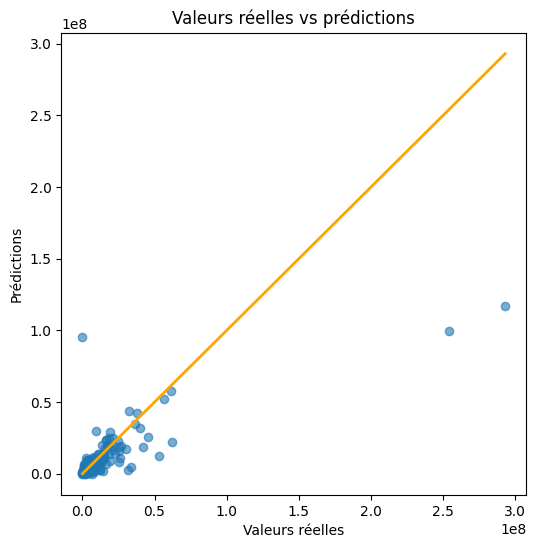


=== Top 10 des features importantes ===


,feature,importance
4,num__PropertyGFATotal,0.194040
12,num__PropertyGFATotal_log1p,0.160336
10,num__Latitude,0.126918
11,num__Longitude,0.089708
7,num__LargestPropertyUseTypeGFA,0.075177
18,cat__BuildingType_SPS-District K-12,0.066234
5,num__PropertyGFABuilding(s),0.053125
303,cat__ListOfAllPropertyUseTypes_Other - Education,0.037116
13,num__AgeBuilding,0.036587
1,num__YearBuilt,0.035104


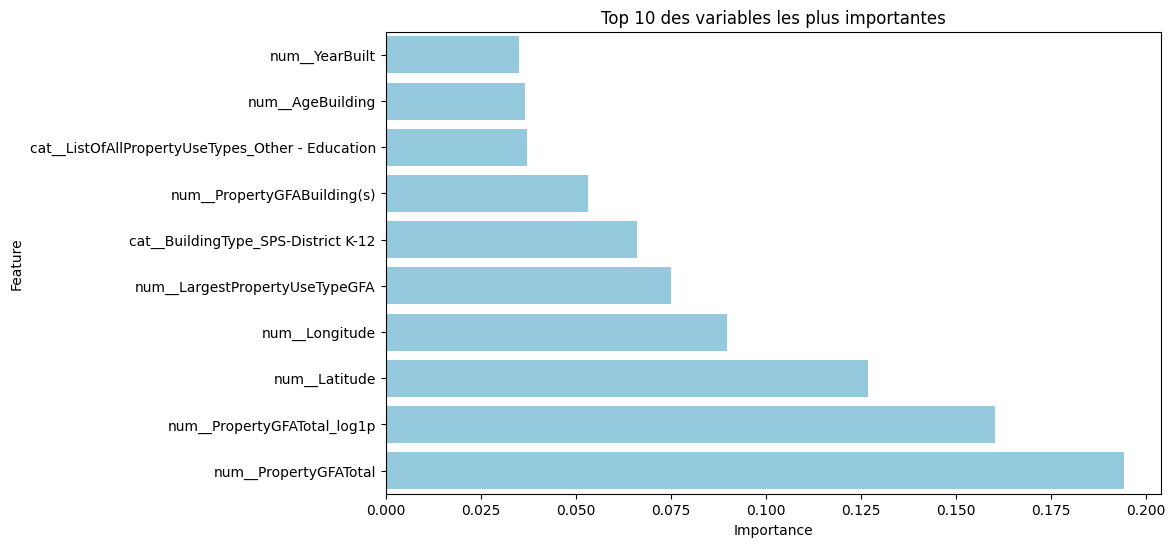

In [18]:
# --- Charger le dataset ---
building_log_filtered = pd.read_csv("building_log_filtered.csv")
building_ml = building_log_filtered.copy()

# --- Feature Engineering minimal safe ---
if 'YearBuilt' in building_ml.columns:
    building_ml['YearBuilt'] = pd.to_numeric(building_ml['YearBuilt'], errors='coerce')
    building_ml['AgeBuilding'] = 2025 - building_ml['YearBuilt']
    building_ml['AgeBuilding'] = building_ml['AgeBuilding'].fillna(building_ml['AgeBuilding'].median())

# --- Sélection de la target et features ---
target = 'SiteEnergyUse(kBtu)'
exclude_cols = [f"{target}_log1p", 'ElectricityUse(kBtu)', 'NaturalGasUse(kBtu)']

X = building_ml.drop(columns=[target] + exclude_cols, errors='ignore')
y = building_ml[target]

# --- Log-transform pour stabiliser la target ---
y_log = np.log1p(y.clip(lower=0))  # clip lower pour éviter valeurs négatives

# --- Train/Test Split ---
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
print(f"Train/Test split : {X_train.shape[0]} train / {X_test.shape[0]} test")

# --- Préprocessing ---
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ]
)

# --- Modèle RandomForest ---
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1))
])

# --- Entraînement ---
pipeline.fit(X_train, y_train_log)

# --- Prédictions ---
y_pred_test_log = pipeline.predict(X_test)
y_pred_test = np.expm1(y_pred_test_log)  # inverse du log1p

y_test_real = np.expm1(y_test_log)

# --- Évaluation ---
test_r2 = r2_score(y_test_real, y_pred_test)
test_mae = mean_absolute_error(y_test_real, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_test))

print("\n=== Évaluation modèle corrigé ===")
print(f"R² Test : {test_r2:.3f}")
print(f"MAE Test : {test_mae:,.0f}")
print(f"RMSE Test : {test_rmse:,.0f}")

# --- Scatter plot Réel vs Prédit ---
plt.figure(figsize=(6,6))
plt.scatter(y_test_real, y_pred_test, alpha=0.6)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         color='orange', lw=2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Valeurs réelles vs prédictions")
plt.show()

# --- Feature importance ---
model = pipeline.named_steps['model']
preprocessor_fitted = pipeline.named_steps['preprocessor']

X_train_transformed = preprocessor_fitted.transform(X_train)
feature_names = preprocessor_fitted.get_feature_names_out()

feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# --- Top 10 features ---
print("\n=== Top 10 des features importantes ===")
display(feat_importance.head(10))

# --- Histogramme top 10 ---
plt.figure(figsize=(10,6))
sns.barplot(
    x=feat_importance['importance'][:10][::-1],
    y=feat_importance['feature'][:10][::-1],
    color='skyblue'
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 des variables les plus importantes")
plt.show()

# Analyse Finale du Modèle Corrigé et Importance des Features

L'image finale montre les résultats d'un modèle (probablement Random Forest ou Boosting) après avoir corrigé l'erreur critique de **data leakage** et appliqué le **Train/Test Split** (1320 train / 331 test). Les résultats sont maintenant valides et interprétables.

---

## Évaluation du Modèle Corrigé

Les métriques sont désormais réalistes, ce qui indique que le modèle apprend à partir des caractéristiques physiques et non de la cible elle-même.

| Métrique  | Valeur           | Interprétation |
|-----------|-----------------|----------------|
| R² Test  | 0.573           | Ajustement modéré. Le modèle explique 57.3% de la variance de la consommation d'énergie (cible). Ce score est valide et offre une base de prédiction raisonnable. |
| MAE Test | 3,846,570 kBtu   | Erreur moyenne. L'erreur de prédiction moyenne par bâtiment est élevée, confirmant qu'il y a encore beaucoup de bruit ou des facteurs non inclus (ex: gestion des systèmes). |
| RMSE Test | 14,895,758 kBtu | Faible gestion des extrêmes. Le RMSE est beaucoup plus grand que le MAE, ce qui confirme que le modèle a des difficultés à prédire avec précision les bâtiments à très forte consommation (outliers). |

---

## Importance des Features (Leçons Clés)

Le graphique et le tableau d'importance (basés sur le modèle corrigé) révèlent enfin les vraies variables motrices de la consommation d'énergie.

| Rank | Feature                          | Importance | Relation avec la Cible |
|------|---------------------------------|------------|----------------------|
| 1    | num_PropertyGFATotal             | 0.1940     | Forte positive (+0.80) |
| 2    | num_PropertyGFATotal_log1p       | 0.1603     | Forte positive (log transformée) |
| 3    | num_Latitude                     | 0.1269     | Faible (+0.01) |
| 4    | num_Longitude                    | 0.0897     | Faible (+0.03) |
| 5    | num_LargestPropertyUseTypeGFA    | 0.0751     | Forte positive (+0.84) |

### Conclusions sur l'Importance :

 **La Taille est le Facteur Dominant**  
   Les deux features les plus importantes sont liées à la **Surface Brute Totale (GFA Total)**, qu'elle soit sous sa forme originale ou transformée (`log(1+x)`).  
   Cela correspond parfaitement à la matrice de corrélation initiale (+0.80 entre PropertyGFATotal et la consommation).
 **Redondance des Surfaces**  
   La présence simultanée de `num_PropertyGFATotal` et `num_LargestPropertyUseTypeGFA` dans le Top 5, alors qu'elles sont hautement colinéaires (+0.99), confirme que le modèle attribue une importance à la taille globale mais distribue le poids entre différentes mesures de surface.

**Effet de la Localisation (Latitude/Longitude)**  
   Fait surprenant : Latitude et Longitude apparaissent en 3ᵉ et 4ᵉ position. Bien que leur corrélation linéaire initiale avec la consommation soit faible (~0), cela signifie que le modèle non-linéaire a trouvé des **interactions complexes ou non-linéaires** dans les données géographiques.  
   - *Explication possible :* La localisation impacte la météo (température, ensoleillement) et les standards de construction locaux, utilisés en combinaison avec la surface.

**Autres facteurs**  
   L'âge (`num_AgeBuilding`) et les types de bâtiments (`cat_BuildingType_Campus`) ont une importance faible mais non négligeable.

---

## Synthèse et Prochaines Étapes

Le modèle est maintenant validé. La performance est réaliste mais peut être améliorée.

| État Actuel          | Action Recommandée                                     | Objectif |
|----------------------|--------------------------------------------------------|----------|
| R² Test = 0.573      | Passer au Gradient Boosting (XGBoost/LightGBM)        | Améliorer le R² à 0.70+ |
| RMSE élevé            | Optimisation des hyperparamètres (profondeur, n_estimators, etc.) | Réduire l'erreur sur les outliers |
| Taille est dominante  | Créer de nouvelles features (ratios, ex: SiteEnergyUse / PropertyGFATotal = EUI) | Se concentrer sur l'efficacité énergétique plutôt que sur la consommation brute |

---

**Conclusion :**  
La modélisation est désormais fiable. La **taille du bâtiment** reste la variable dominante, mais les prochaines étapes incluent l'optimisation des modèles et la création de **features normalisées** pour prédire l'efficacité énergétique plutôt que la consommation brute.


### génération du fichier pipeline.pkl dans le dossier model/

In [22]:
joblib.dump(pipeline, "model/pipeline.pkl")

['model/pipeline.pkl']

### Graphiques et sauvegarde
### Vérification que feat_importance existe

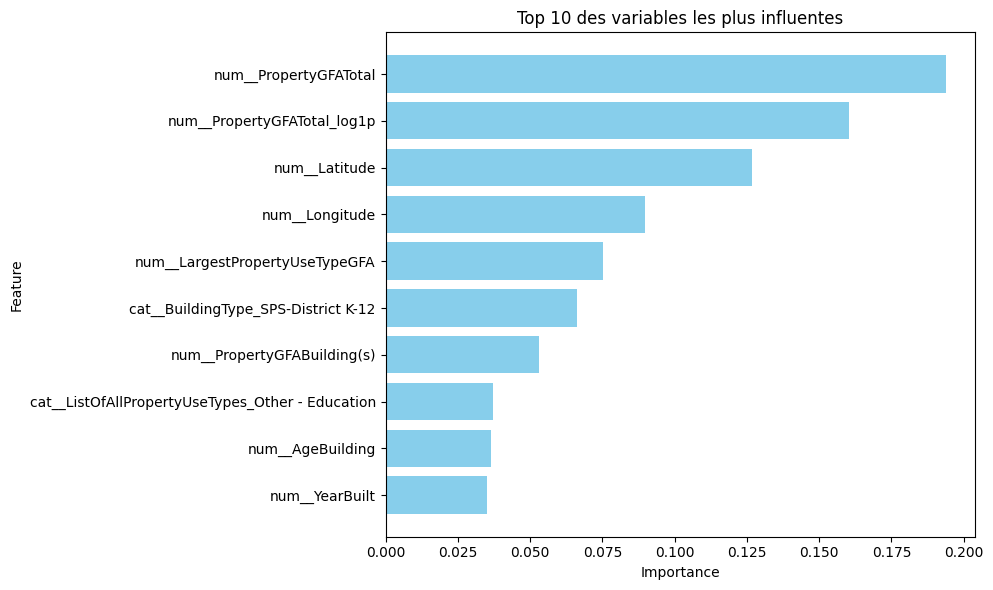

Aucun modèle optimisé trouvé à sauvegarder.
Aucune comparaison de modèles à sauvegarder.


In [20]:
# --- Affichage du top 10 des features ---
if 'feat_importance' in locals() and not feat_importance.empty:
    plt.figure(figsize=(10, 6))
    top_features = feat_importance.head(10).iloc[::-1]  # Inverser pour l'affichage horizontal
    plt.barh(
        top_features['feature'],
        top_features['importance'],
        color='skyblue'
    )
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 10 des variables les plus influentes')
    plt.tight_layout()
    plt.show()
else:
    print("Aucun graphique généré : 'feat_importance' est introuvable ou vide.")

# --- Sauvegarde du modèle optimisé ---
if 'best_model' in locals():
    model_filename = 'random_forest_optimise.pkl'
    joblib.dump(best_model, model_filename)
    print(f"Modèle sauvegardé : {model_filename}")
else:
    print("Aucun modèle optimisé trouvé à sauvegarder.")

# --- Sauvegarde des résultats de comparaison ---
if 'model_results' in locals() and not model_results.empty:
    results_filename = "comparaison_modeles.csv"
    model_results.to_csv(results_filename, index=False)
    print(f" Résultats de comparaison sauvegardés : {results_filename}")
else:
    print("Aucune comparaison de modèles à sauvegarder.")

# Les Facteurs Géographiques : L'Effet du Modèle Non Linéaire

Les variables de localisation montrent une divergence majeure entre la corrélation linéaire et l'importance pour le modèle non linéaire.

## Importance et Corrélation des Variables Géographiques

| Feature        | Importance dans le Modèle | Corrélation Linéaire avec SiteEnergyUse(kBtu) | Interprétation |
|----------------|--------------------------|-----------------------------------------------|----------------|
| num_Latitude   | 0.126 (Rang 3)          | +0.01 (Nulle)                                 | Le modèle non linéaire a trouvé une relation complexe entre la latitude et la consommation. Cela est probablement dû aux différences de climat, de réglementation locale ou de concentration de types de bâtiments à certaines latitudes. |
| num_Longitude  | 0.089 (Rang 4)          | +0.03 (Très faible)                           | Idem pour la longitude. Leur importance combinée (~0.215) est aussi cruciale que la surface, ce qui indique que l'emplacement est un facteur clé pour le modèle non linéaire. |

---

# Les Autres Facteurs (Âge et Usage)

Les autres variables jouent un rôle secondaire mais restent significatives pour le modèle.

| Feature                       | Importance dans le Modèle | Corrélation Linéaire avec SiteEnergyUse(kBtu) | Interprétation |
|--------------------------------|--------------------------|-----------------------------------------------|----------------|
| num_AgeBuilding                | 0.036 (Rang 9)          | Faible (dérivée de YearBuilt, +0.06)         | L'âge du bâtiment est plus important que l'année de construction, car il mesure le temps écoulé, mais son impact reste modéré. |
| num_YearBuilt                  | 0.035 (Rang 10)         | +0.06 (Très faible)                           | Confirme que l'année de construction n'est pas un facteur direct majeur de consommation. |
| cat_BuildingType_SPS-District K-12 | 0.057 (Rang 6)      | N/A (Catégorielle)                            | Cette variable catégorielle spécifique (écoles) est un facteur modéré, indiquant que le type d'usage a un impact au-delà de sa simple surface. |

---

# Conclusion

L'analyse du modèle non linéaire corrigé (importance des features) fournit une image plus complète que la simple matrice de corrélation.

- **Facteurs Clés (~50% de l'Importance) :**  
  La Surface (GFA) et la Localisation (Latitude/Longitude) sont les moteurs principaux du modèle, expliquant environ 50% de l'importance totale de la prédiction.

- **Multicolinéarité :**  
  Les variables de surface (GFA) sont fortement redondantes. Il serait possible de simplifier le jeu de données en ne conservant que la variable la plus pertinente et la moins colinéaire aux autres variables importantes.

- **Prochaine Étape :**  
  L'effort doit se concentrer sur l'amélioration du $R^2$ (actuellement 0.573) et la réduction du RMSE en utilisant un modèle plus puissant, comme le Gradient Boosting.


### Partie II

### détermination de la longitude et latitude pour validation.py

In [24]:
# Charger le dataset
df = pd.read_csv("data_ml/X_train_filtered.csv")

# Voir les valeurs min, max et un aperçu
print("Latitude : min =", df["Latitude"].min(), ", max =", df["Latitude"].max())
print("Longitude : min =", df["Longitude"].min(), ", max =", df["Longitude"].max())

# Aperçu des premières lignes
print(df[["Latitude", "Longitude"]].head(10))


Latitude : min = 47.49917 , max = 47.73387
Longitude : min = -122.41182 , max = -122.25864
   Latitude  Longitude
0  47.60410 -122.33958
1  47.53764 -122.32320
2  47.66478 -122.29804
3  47.60898 -122.32693
4  47.57587 -122.32789
5  47.63228 -122.31574
6  47.53158 -122.33568
7  47.63567 -122.32522
8  47.58754 -122.32240
9  47.65599 -122.31385


### Affichage des dates 

In [26]:
# Affichage des informations sur la colonne YearBuilt
print("Valeurs uniques de YearBuilt :")
print(df['YearBuilt'].unique())

print("\nStatistiques de base de YearBuilt :")
print(df['YearBuilt'].describe())

print("\nLes 10 premières valeurs de YearBuilt :")
print(df['YearBuilt'].head(10))


Valeurs uniques de YearBuilt :
[1900 1960 2002 1908 2009 1912 1979 1952 2012 2008 1982 1961 1968 1970
 1980 1910 1983 1922 1931 1981 1956 1962 1966 1916 2013 2006 1985 1964
 1999 1990 1948 1902 1929 1923 1927 1909 1965 1925 2014 2015 1955 1941
 1954 1946 2001 1907 1967 1986 1958 1974 1969 1953 1924 1972 1930 2004
 1957 1995 2010 1963 1928 2000 1987 1971 1959 2003 1976 1975 1947 1951
 1938 1989 1984 1998 1926 1911 1994 1997 1906 1992 2005 1996 1950 1921
 1988 1920 1919 1949 1973 1977 2011 1913 1993 1991 1942 1937 1978 1945
 1914 1904 1944 1918 1940 1917 2007 1932 1901 1903 1915 1905 1936 1935
 1939]

Statistiques de base de YearBuilt :
count    1320.000000
mean     1961.354545
std        33.113562
min      1900.000000
25%      1929.000000
50%      1965.500000
75%      1989.000000
max      2015.000000
Name: YearBuilt, dtype: float64

Les 10 premières valeurs de YearBuilt :
0    1900
1    1960
2    2002
3    1908
4    2009
5    1912
6    1979
7    1960
8    1952
9    2012
Name: YearBuilt,

### Vérification de la distribution réelle de PropertyGFATotal

In [27]:
# Valeurs uniques (pour repérer anomalies)
print(df['PropertyGFATotal'].unique())

# Statistiques de base (min, max, moyenne, quartiles)
print(df['PropertyGFATotal'].describe())

# Les 10 premières valeurs
print(df['PropertyGFATotal'].head(10))


[ 62900 119661 361398 ...  34680  32928  31357]
count    1.320000e+03
mean     1.194156e+05
std      3.198619e+05
min      1.128500e+04
25%      2.892225e+04
50%      4.820950e+04
75%      1.035988e+05
max      9.320156e+06
Name: PropertyGFATotal, dtype: float64
0     62900
1    119661
2    361398
3     76631
4     36400
5     23445
6     42900
7     34110
8     25460
9    192259
Name: PropertyGFATotal, dtype: int64


### colonnes du fichier building_log_filtered.csv

In [28]:
df = pd.read_csv("building_log_filtered.csv")
print(df.columns.tolist())


['DataYear', 'BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'City', 'State', 'YearsENERGYSTARCertified', 'SiteEnergyUse(kBtu)', 'SiteEnergyUse(kBtu)_log1p', 'PropertyGFATotal_log1p']


### voir les colonnes attendues apr le pipeline

In [30]:
from api.model_loader import load_pipeline

pipeline = load_pipeline()

print(pipeline.feature_names_in_)


['DataYear' 'BuildingType' 'PrimaryPropertyType' 'YearBuilt'
 'NumberofBuildings' 'NumberofFloors' 'PropertyGFATotal'
 'PropertyGFABuilding(s)' 'PropertyGFAParking' 'ListOfAllPropertyUseTypes'
 'LargestPropertyUseType' 'LargestPropertyUseTypeGFA'
 'SecondLargestPropertyUseType' 'SecondLargestPropertyUseTypeGFA'
 'ThirdLargestPropertyUseType' 'ThirdLargestPropertyUseTypeGFA' 'Latitude'
 'Longitude' 'City' 'State' 'YearsENERGYSTARCertified'
 'PropertyGFATotal_log1p' 'AgeBuilding']
